In [53]:
import numpy as np
import matplotlib.pyplot as plt
# import MC_autocall

# Parameters
S0 = 100  # Initial price of the underlying asset
sigma = 0.2  # Annual volatility of the asset
r = 0.05  # Annual risk-free rate
T = 1  # Maturity of the product in years
m = 12  # Number of observation dates
n = 10^5 # Number of Monte Carlo simulations
yield_rate = 0.06  # Coupon yield rate
barrier = 0.8  # Barrier level as a percentage of the initial level


def Observation(n, m, S0, r, sigma, T, W_t=None):
    # Time points for each observation
    dt = T / m
    observation_times = np.linspace(dt, T, m)  # (m,)

    # Generate or use provided standard Brownian motion paths (n, m)
    if W_t is None:
        W_t = np.random.randn(n, m) * np.sqrt(dt)  # Generate new if not provided
    else:
        W_t *= np.sqrt(dt)  # Scale the provided paths by the square root of time

    # Cumulative sum to simulate the Brownian motion paths
    W_t = np.cumsum(W_t, axis=1)

    # Calculate asset price at each observation using the Black-Scholes formula
    exponent = (r - 0.5 * sigma**2) * observation_times + sigma * W_t
    paths = S0 * np.exp(exponent)

    # Insert the initial price at the beginning of each path
    Obs = np.c_[np.full((n, 1), S0), paths]
    
    return Obs


def autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, W_t=None):
    """
    Calculate the payoff for each simulation path of the autocallable product.
    This function determines the payoff based on the occurrence of early termination and the final asset price relative to the barrier.
    """
    observation = Observation(n, m, S0, r, sigma, T, W_t) # Generate asset paths
    payoffs = []
    for path in observation:
        early_termination = False
        for t in range(1, m + 1):  # Loop over each observation date
            if path[t] > S0:  # Check for early termination condition
                payoffs.append((1 + yield_rate * t))  # Calculate payoff for early termination
                early_termination = True
                break
        if not early_termination:  # If no early termination
            if path[-1] < barrier * S0:  # If asset price is below the barrier at maturity
                payoffs.append(path[-1] / S0)  # Payoff is the negative performance
            else:  # If asset price is above the barrier
                payoffs.append(1)  # No payoff as the asset price is above the barrier
    return np.array(payoffs)

def MC_autocall(S0, barrier, yield_rate, n, m, r, sigma, T):
    """
    Perform Monte Carlo simulation to calculate the average expected payoff of the autocallable product.
    This function averages the payoffs from all simulation paths and discounts them to present value.
    """
    payoffs = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T)  # Calculate payoffs for each path
    return np.mean(payoffs) * np.exp(-r * T)  # Discount payoffs to present value and calculate average

def MC_confidence(S0, barrier, yield_rate, n, m, r, sigma, T):
    """
    Give some information about the monte carlo estimator (standard dev, confidence interval, error)
    """
    payoffs = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T) 
    p=np.mean(payoffs) * np.exp(-r * T) 
    s=np.std(payoffs*np.exp(-r*T))
    print("Estimator:",p)
    print("Standard deviation:",s/np.sqrt(n)) 
    print("Condidence interval 95%:",[p-1.96*s/np.sqrt(n),p+1.96*s/np.sqrt(n)]) #Confidence interval of level 95%
    print("Error:",100*1.96*s/(p*np.sqrt(n)),"%")

    
def calculate_delta(S0, barrier, yield_rate, n, m, r, sigma, T, delta_S=0.1):
    # Generate a single set of Brownian motion paths for consistency
    W_t = np.random.randn(n, m)

    # Calculate prices for the up and down scenarios
    price_up = autocall_payoff(S0 + delta_S, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)
    price_down = autocall_payoff(S0 - delta_S, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)

    # Return the Delta
    return (price_up - price_down) / (2 * delta_S)


def calculate_gamma(S0, barrier, yield_rate, n, m, r, sigma, T, delta_S=0.1):
    # Generate a single set of Brownian motion paths for consistency
    W_t = np.random.randn(n, m)

    # Calculate prices for the up, down, and base scenarios
    price_up = autocall_payoff(S0 + delta_S, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)
    price_down = autocall_payoff(S0 - delta_S, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)
    base_price = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)

    # Return the Gamma
    return (price_up - 2 * base_price + price_down) / (delta_S**2)

def calculate_vega(S0, barrier, yield_rate, n, m, r, sigma, T, delta_sigma=0.0002):
    # Generate a single set of Brownian motion paths for consistency
    W_t = np.random.randn(n, m)

    # Calculate prices for the original and increased volatility scenarios
    base_price = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma, T, W_t=W_t)
    price_vol_up = autocall_payoff(S0, barrier, yield_rate, n, m, r, sigma + delta_sigma, T, W_t=W_t)

    # Return the Vega
    return (price_vol_up - base_price) / delta_sigma


In [57]:
Delta = calculate_delta(S0, barrier, yield_rate, n, m, r, sigma, T)
Gamma = calculate_gamma(S0, barrier, yield_rate, n, m, r, sigma, T)
Vega = calculate_vega(S0, barrier, yield_rate, n, m, r, sigma, T)

print(f"In our setting, Average Delta: {np.mean(Delta)}, Average Gamma: {np.mean(Gamma)}, Average Vega: {np.mean(Vega)}")


In our setting, Average Delta: -0.2485827309696498, Average Gamma: 8.440628736584857, Average Vega: -100.0


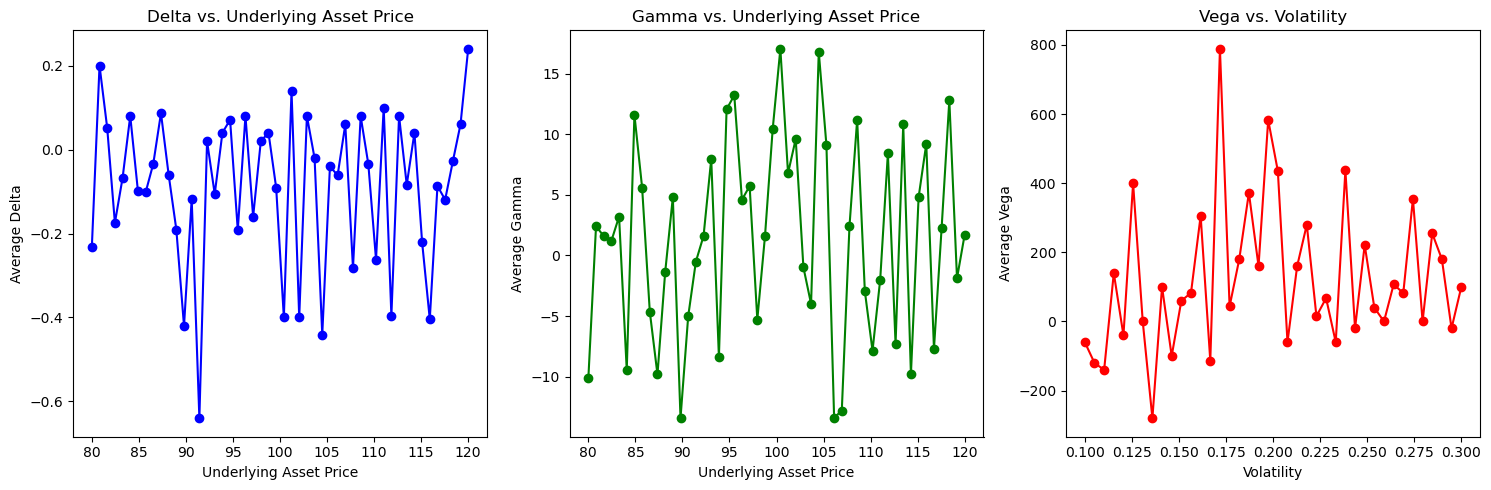

In [58]:
# Define ranges for the parameters
S_range = np.linspace(80, 120, 50)  # Range for underlying asset prices
sigma_range = np.linspace(0.1, 0.3, 40)  # Range for volatility

# Initialize lists to hold the average Greeks
average_deltas = []
average_gammas = []
average_vegas = []

# Calculate average Delta and Gamma for different values of S0
for S in S_range:
    Delta = calculate_delta(S, barrier, yield_rate, n, m, r, sigma, T)
    Gamma = calculate_gamma(S, barrier, yield_rate, n, m, r, sigma, T)
    average_deltas.append(np.mean(Delta))
    average_gammas.append(np.mean(Gamma))

# Calculate average Vega for different values of sigma
for vol in sigma_range:
    Vega = calculate_vega(S0, barrier, yield_rate, n, m, r, vol, T)
    average_vegas.append(np.mean(Vega))

# Plotting the results
plt.figure(figsize=(15, 5))

# Plot for Delta
plt.subplot(1, 3, 1)
plt.plot(S_range, average_deltas, '-o', color='blue')
plt.title('Delta vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Average Delta')

# Plot for Gamma
plt.subplot(1, 3, 2)
plt.plot(S_range, average_gammas, '-o', color='green')
plt.title('Gamma vs. Underlying Asset Price')
plt.xlabel('Underlying Asset Price')
plt.ylabel('Average Gamma')

# Plot for Vega
plt.subplot(1, 3, 3)
plt.plot(sigma_range, average_vegas, '-o', color='red')
plt.title('Vega vs. Volatility')
plt.xlabel('Volatility')
plt.ylabel('Average Vega')

plt.tight_layout()
plt.show()
